In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import autobet.ocr_model as ocr_model
from PIL import Image, ImageDraw, ImageFont
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

In [2]:
NUMBER_FONT = ImageFont.truetype('ChaletLondonNineteenSixty.ttf', 20)
LETTER_FONT = ImageFont.truetype('ChaletNewYorkNineteenSixty.ttf', 15)
TRAIN_DATASET_SIZE = 30_000
TEST_DATASET_SIZE = 3_000
TRAIN_PATH = '/storage/gta/training_data/train_images'
TEST_PATH = '/storage/gta/training_data/test_images'

BATCH_SIZE = 256

In [3]:
def generate_example(odd):
    rand_bg = random.randint(200, 255)
    img = Image.new('L', ocr_model.INPUT_SHAPE[:2], color=(rand_bg,))
    d = ImageDraw.Draw(img)
    rand_x = random.randint(0, 10)
    rand_y = random.randint(5, 15)
    rand_fg = random.randint(0, 55)
    if odd != 1:
        d.text((rand_x,rand_y), f'{odd}/1', font=NUMBER_FONT, fill=rand_fg)
    else:
        d.text((rand_x,rand_y), 'EVENS', font=LETTER_FONT, fill=rand_fg)
    return img

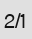

In [4]:
generate_example('2')

In [5]:
# Generate datasets
for path in [TRAIN_PATH, TEST_PATH]:
    for odd in range(30):
        Path(f'{path}/{odd}').mkdir(parents=True, exist_ok=True)

for odd in tqdm(range(30)):
    for i in tqdm(range(TRAIN_DATASET_SIZE // 30), leave=False):
        example = generate_example(odd+1)
        example.save(f'{TRAIN_PATH}/{odd}/{i}.bmp')
    
for odd in tqdm(range(30)):
    for i in tqdm(range(TEST_DATASET_SIZE // 30), leave=False):
        example = generate_example(odd+1)
        example.save(f'{TEST_PATH}/{odd}/{i}.bmp')

In [6]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=30,
    zoom_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.5,1.5)
)

train_dataset = train_image_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=ocr_model.INPUT_SHAPE[:2],
    color_mode="grayscale",
    classes=None,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

test_dataset = test_image_generator.flow_from_directory(
    TEST_PATH,
    target_size=ocr_model.INPUT_SHAPE[:2],
    color_mode="grayscale",
    classes=None,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 30000 images belonging to 30 classes.
Found 3012 images belonging to 30 classes.


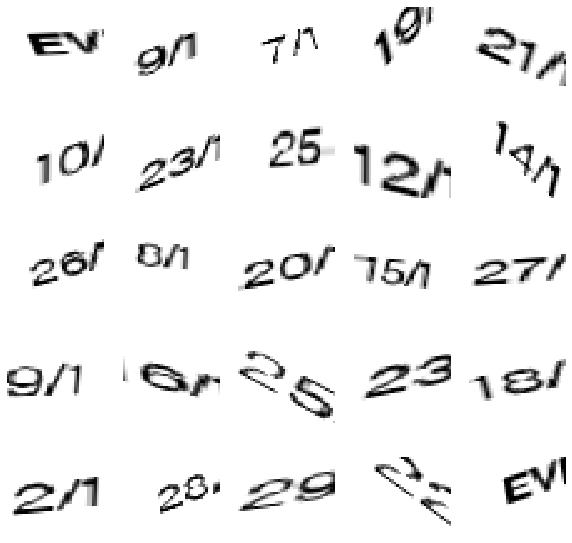

In [7]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n], cmap='gray')
      plt.axis('off')

image_batch, label_batch = next(train_dataset)
show_batch(np.squeeze(image_batch), label_batch)

In [8]:
model = ocr_model.load_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 37, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 35, 32)        9248      
_________________________________________________________________
activation (Activation)      (None, 28, 35, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 17, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 17, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 17, 64)        0

In [ ]:
model.fit_generator(train_dataset, epochs=100, verbose=1)

Epoch 1/100
118/118 [==============================] - 28s 240ms/step - loss: 2.5727 - accuracy: 0.8838
Epoch 2/100
118/118 [==============================] - 28s 238ms/step - loss: 2.5733 - accuracy: 0.8834
Epoch 3/100
 17/118 [===>..........................] - ETA: 24s - loss: 2.5655 - accuracy: 0.8913

In [ ]:
model.evaluate_generator(test_dataset, verbose=1)

In [ ]:
Path(ocr_model.SAVED_MODEL_PATH).mkdir(parents=True, exist_ok=True)
model.save_weights(ocr_model.SAVED_MODEL_PATH)